In [3]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
import skexplain
from os.path import join
import pickle
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import joblib
from bayeshist import bayesian_histogram, plot_bayesian_histogram
import matplotlib.pyplot as plt
from load_models_and_data import load_model_and_data
from matplotlib.ticker import MaxNLocator
from load_explain_data import load_explain

In [4]:
from display_names import to_readable_names, get_units

In [5]:
hazard = 'severe_hail'
(estimator_name, model), X, y = load_model_and_data(hazard)

feature_names = X.columns
display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

Loading /work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_first_hour_severe_hail_under_standard_.pkl...


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Loading data...


In [8]:
ale, shap_ds, shap_vals, X_shap = load_explain(hazard, return_pd=False)

In [16]:
shap_ds.attrs['features'] = X_shap.columns

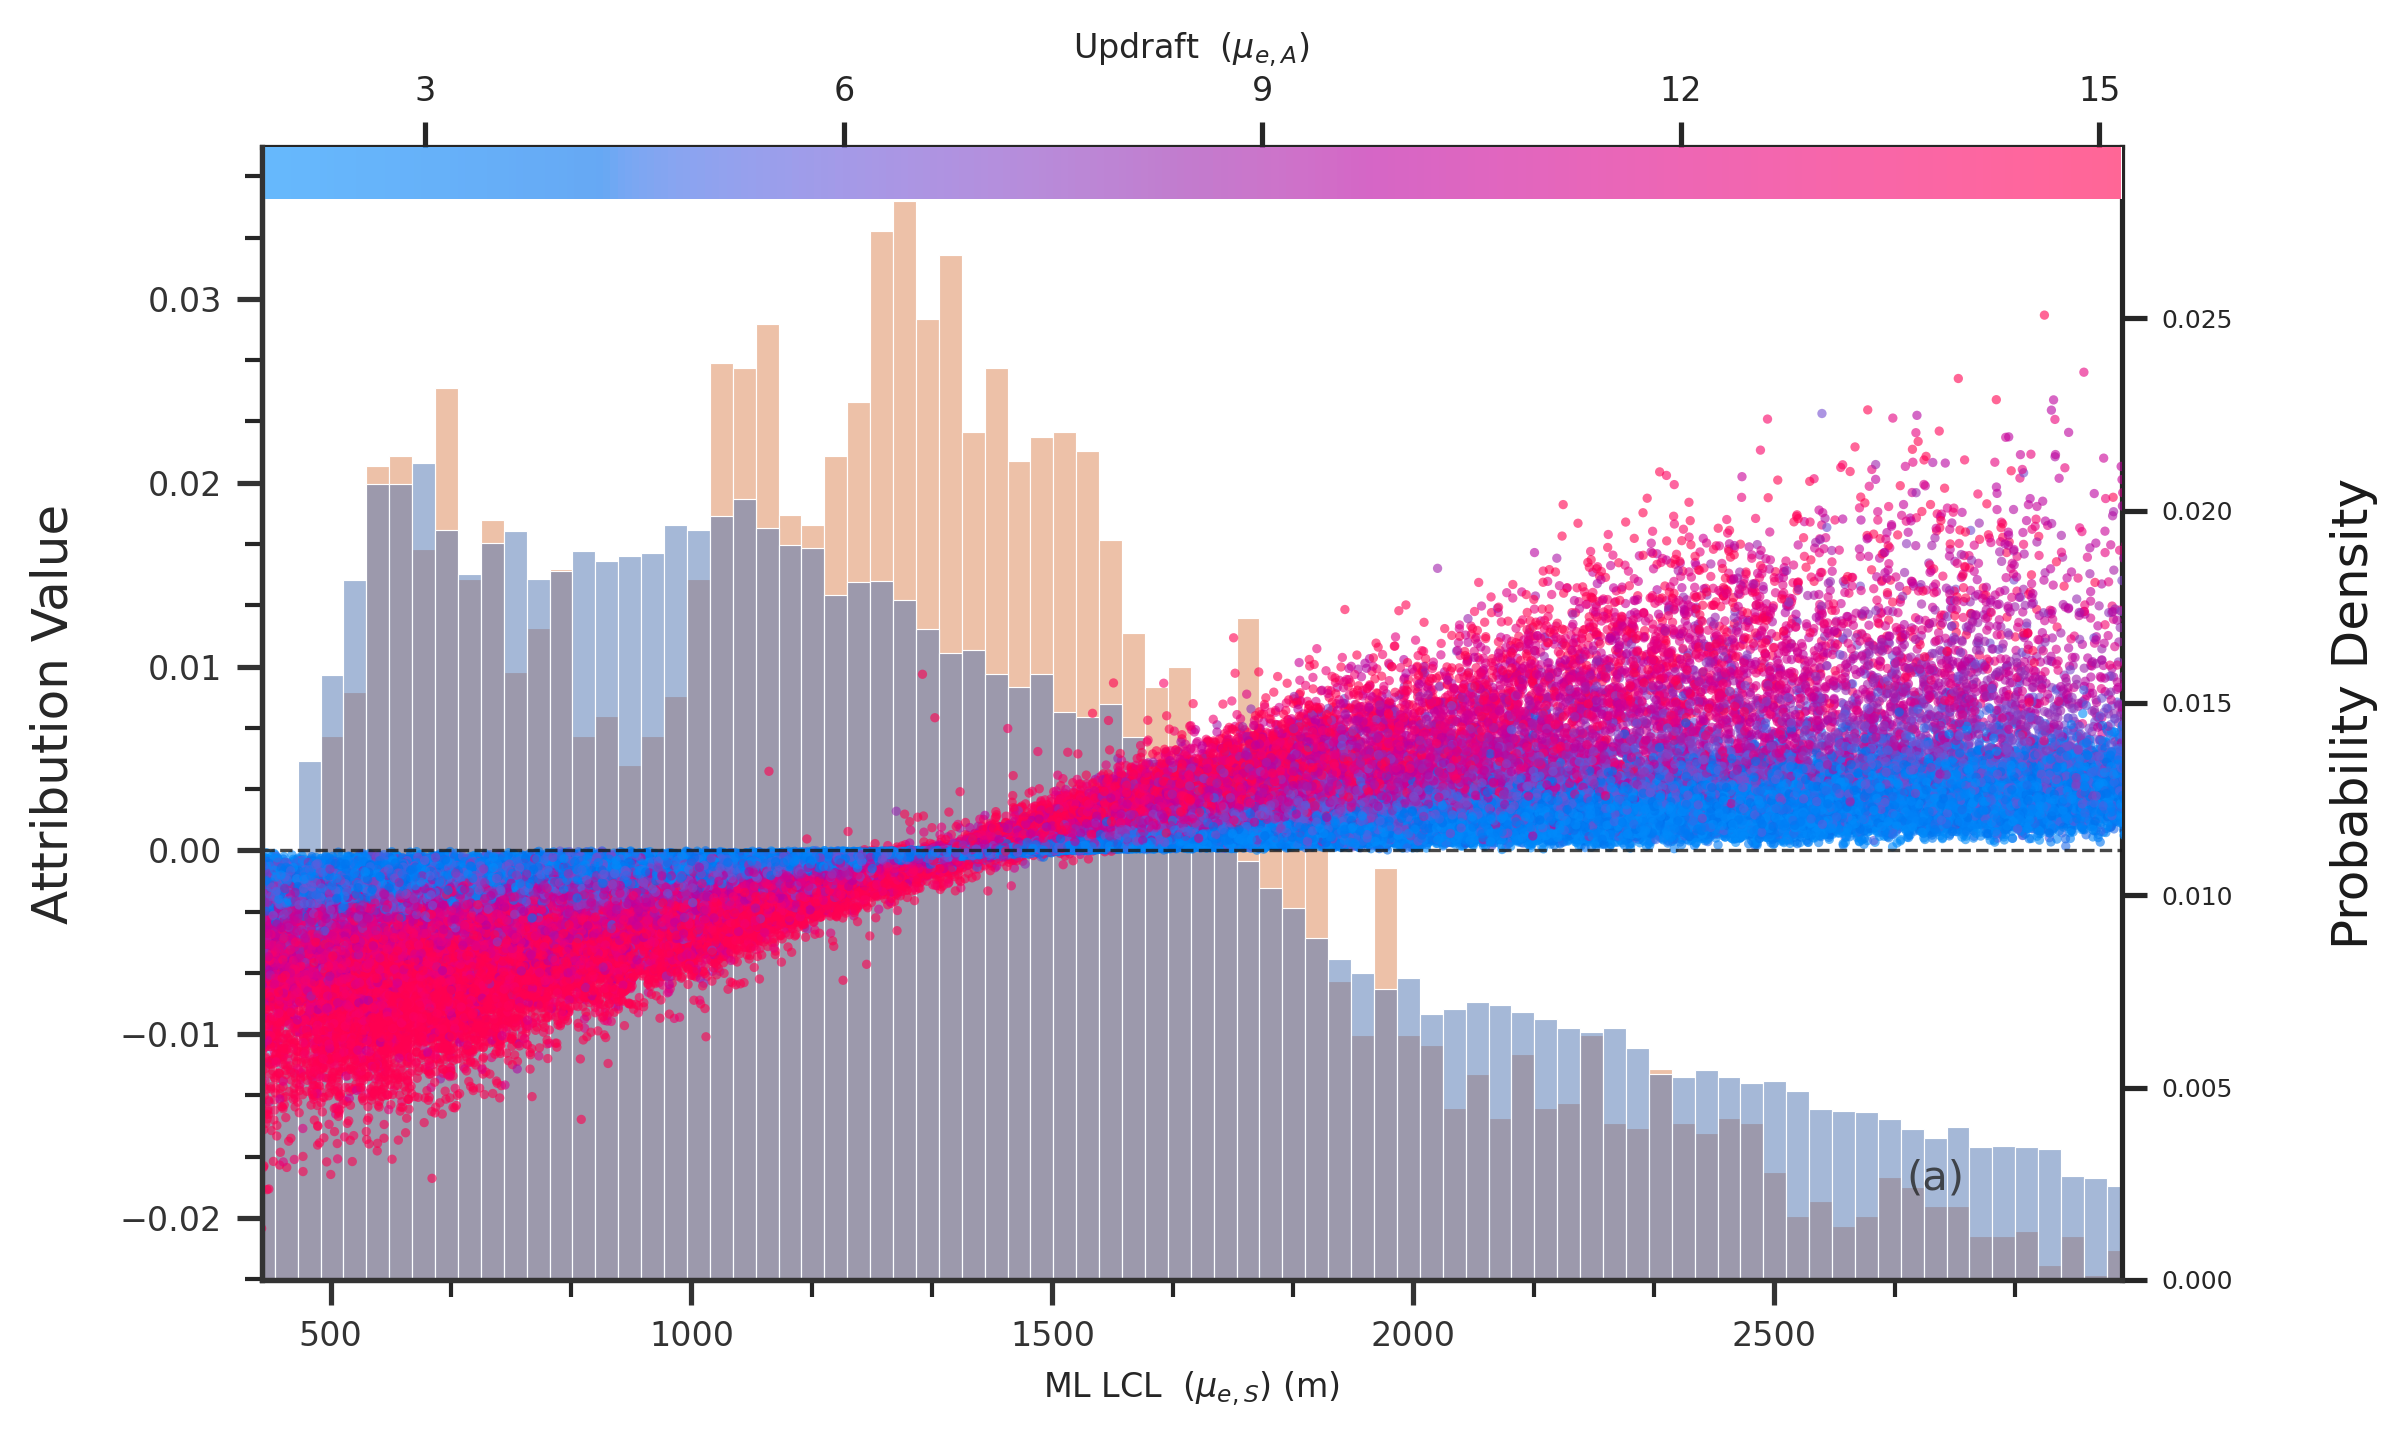

In [19]:
histdata = X_shap.copy()
histdata['target'] = shap_ds['y'].values

explainer = skexplain.ExplainToolkit(X=X_shap, estimator_output='probability')
#features = ['dbz_3to5km_max_time_max_ens_mean_of_90th']
features = ['lcl_ml_ens_mean_spatial_mean']

#features = ['fric_vel', ]

#fig, ax = plt.subplots(dpi=300)

explainer.scatter_plot(features=features,
                    plot_type = 'dependence',
                    method = 'shap',
                    dataset=shap_ds,
                    estimator_name = estimator_name,
                    display_feature_names=display_feature_names,
                    display_units = display_units,
                    interaction_index='auto',
                    s = 5, 
                    alpha=0.6,
                    to_probability=True,
                    colorbar_pad = 0.15, 
                    histdata=histdata,
                    target = 'target', 
    )

#bin_values = ale[f'{features[0]}__bin_values'].values
#shap_mean = shap_to_curve(features[0], shap_vals, X_shap, bin_values)
#ax.plot(bin_values, shap_mean)

In [32]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]
    
    inds = np.digitize(feature_vals, bins=bins)
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200000 but corresponding boolean dimension is 346341

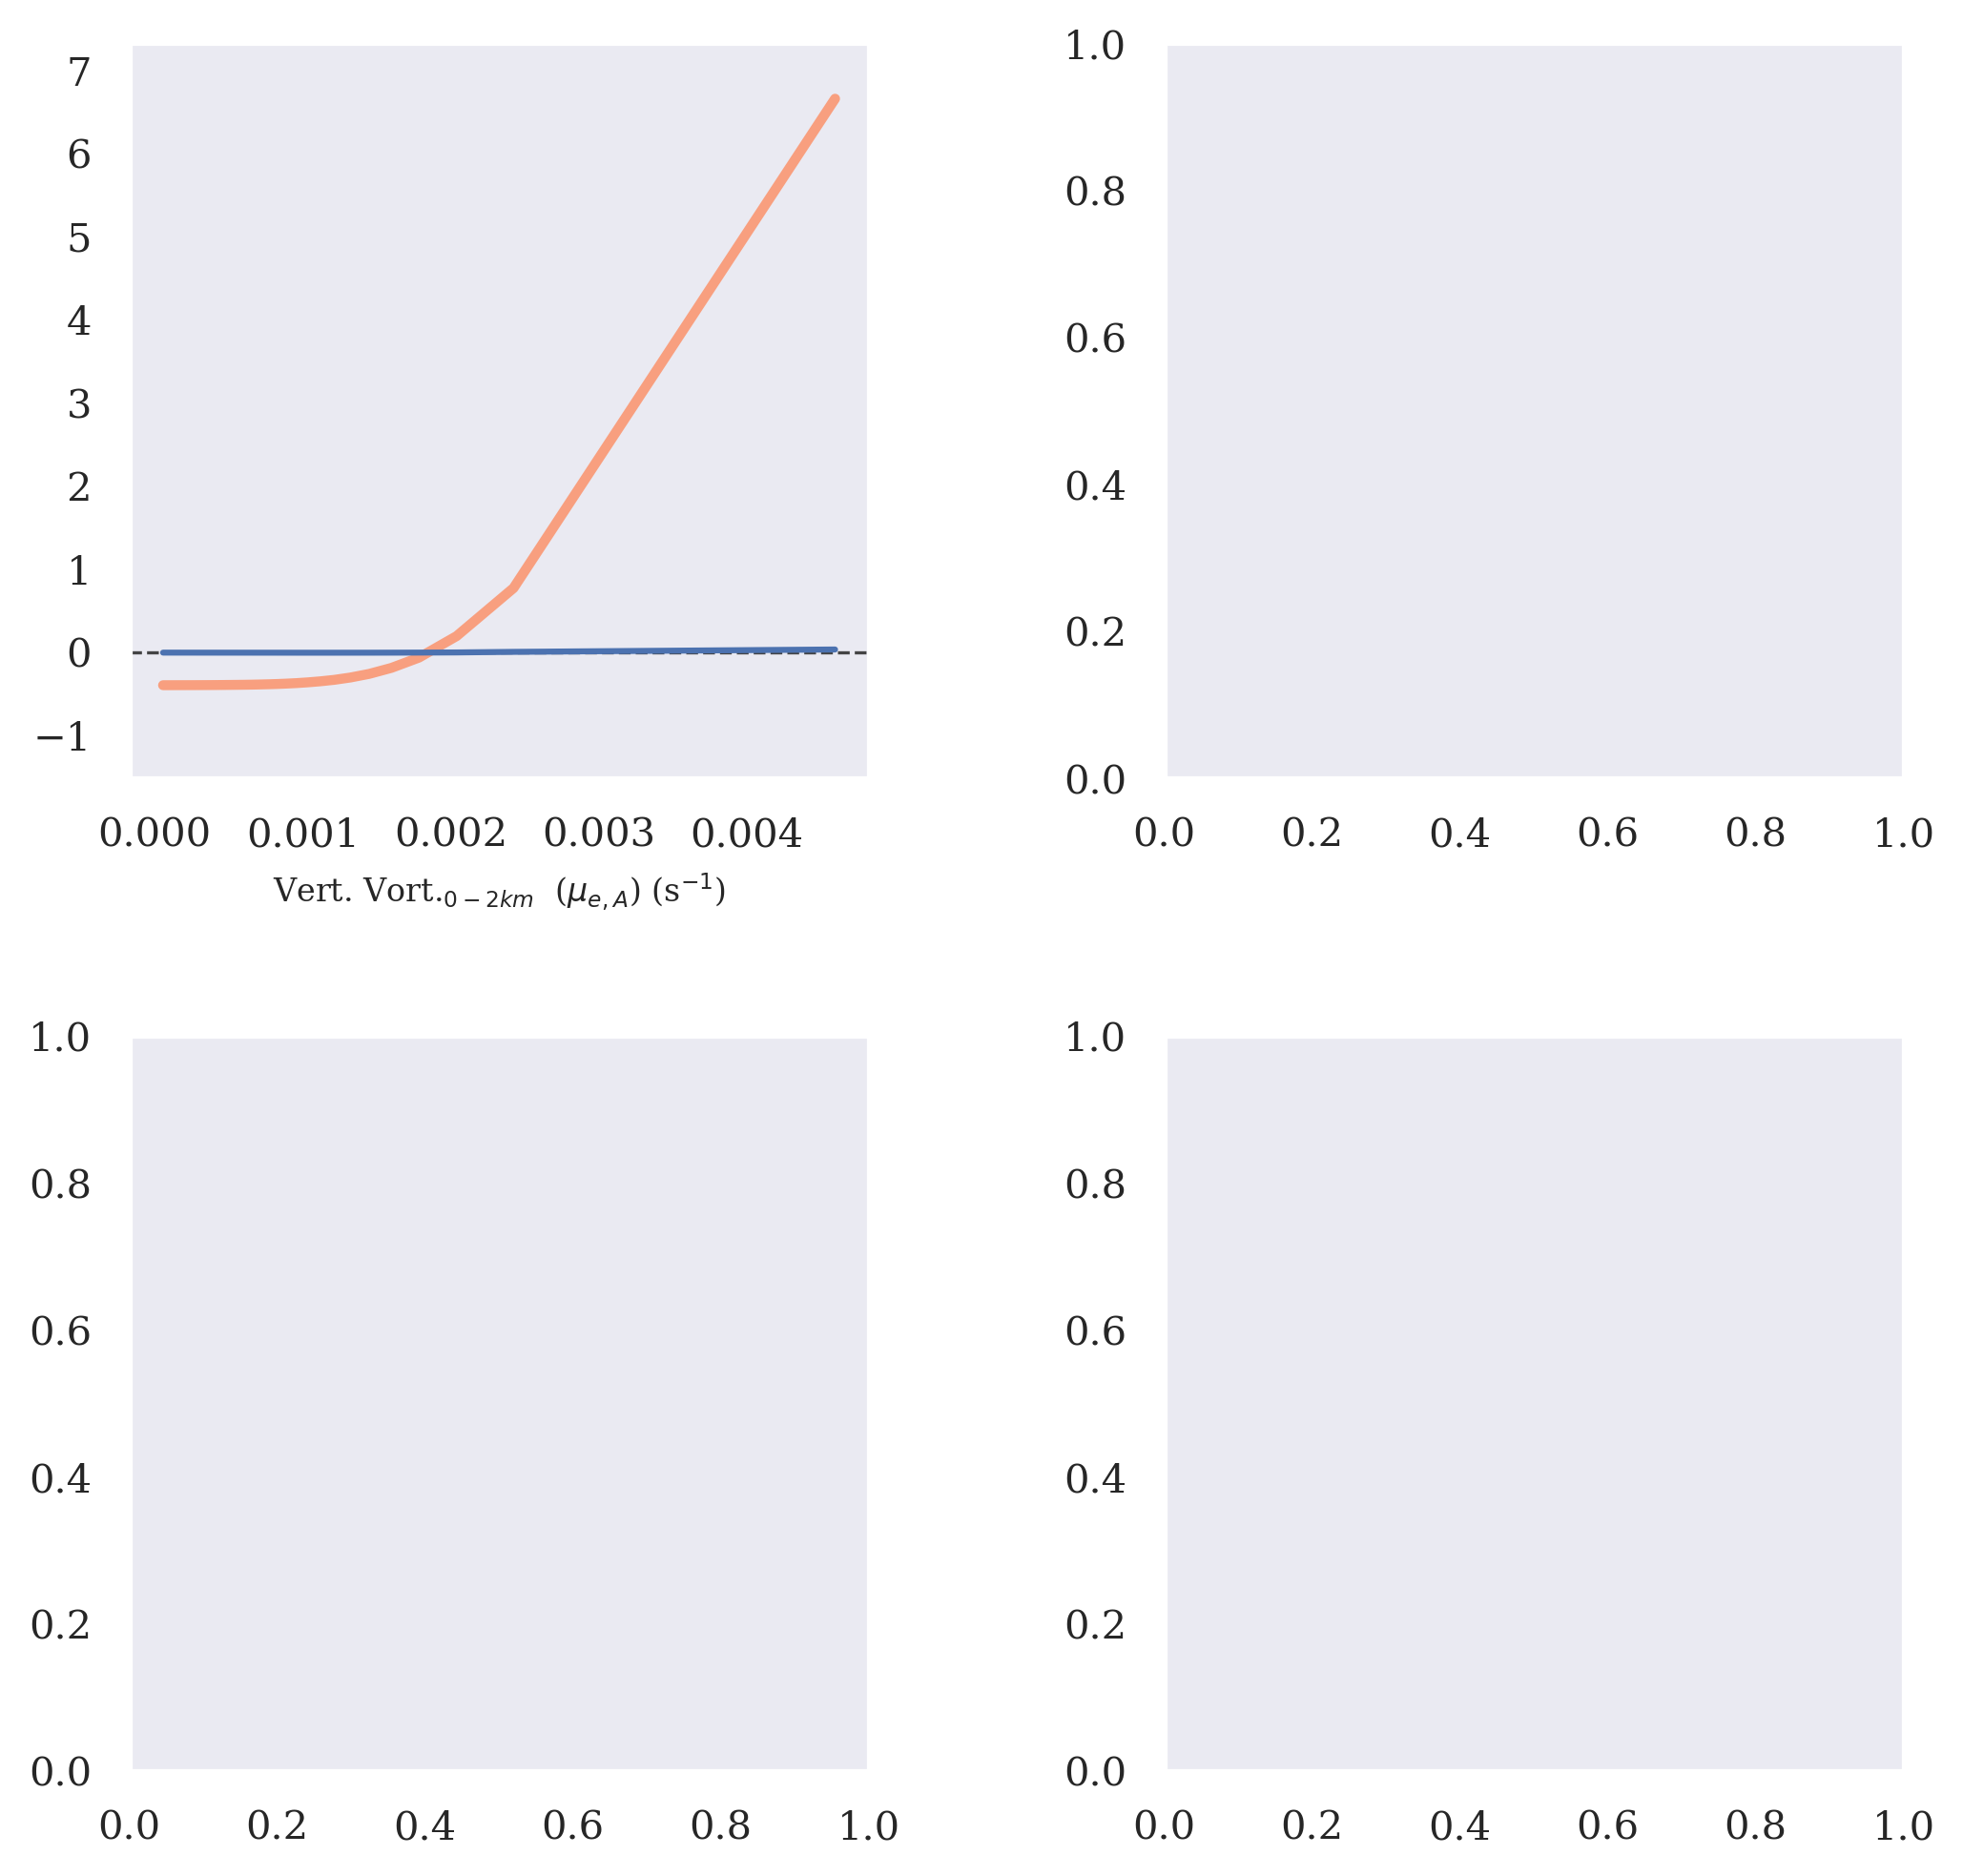

In [43]:
features = ['wz_0to2_time_max_ens_mean_of_90th', 'v_10_ens_mean_spatial_mean', 
            'comp_dz_time_max_ens_mean_of_90th', 'uh_2to5_time_max_ens_mean_of_90th'
           ]

features = ['dbz_3to5km_max_time_max_ens_mean_of_90th']


n_panels=len(features)
plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, axes = plotter.create_subplots(n_panels=len(features), n_columns=2, figsize=(8,8), dpi=300, 
                                      wspace=0.4, hspace=0.35)

for ax in axes.flat:
    ax.grid()

colors = list(sns.color_palette("Set2"))

for ax, feature in zip(axes.flat, features):
    explainer.plot_ale(ale, 
                   features = [feature],
                   estimator_names = [estimator_name],
                   add_hist=False, 
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   ax=ax, line_kws = {'line_colors' : [colors[1]], 'linewidth': 2.5}, 
                   to_probability=True,
                      )

    #bin_values = ale_results[f'{feature}__bin_values'].values
    #shap_mean = shap_to_curve(feature, shap_vals, X_shap, bin_values)
    #ax.plot(bin_values, shap_mean)
    
    # Set add_hist == False since it is already included above.
    """
    explainer.plot_pd(pd_results, 
                  features = [feature],
                  estimator_names = [estimator_name], 
                  ax=ax,
                  add_hist=False, 
                  display_feature_names=display_feature_names,
                  display_units = display_units,
                  line_kws = {'line_colors' : [colors[2]], 'linewidth': 2.0},
                  to_probability=True, 
                 )
    """                 
                 
    explainer.plot_shap(features=[feature],
                    plot_type = 'dependence',
                    shap_values=shap_ds,
                    estimator_name = estimator_name,
                    display_feature_names=display_feature_names,
                    display_units = display_units,
                    interaction_index='auto',
                    color =colors[2],
                    s = 5, 
                    ax=ax,
                    alpha=0.3,
                    to_probability=True,
                    colorbar_pad = 0.25    
    )

    handles, labels = ax.get_legend_handles_labels()
    
    upperbound = max(np.max(ale_results[f'{feature}__{estimator_name}__ale'].values), 
                     np.max(pd_results[f'{feature}__{estimator_name}__pd']).values)*100.
    
    lowerbound = min(np.min(ale_results[f'{feature}__{estimator_name}__ale'].values), 
                     np.min(pd_results[f'{feature}__{estimator_name}__pd'].values))*100.
    
    plotter.set_n_ticks(ax)
    plotter.set_minor_ticks(ax)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([lowerbound*1.1, upperbound*1.1])

    # plot it up
    """
    data = X[feature].values.astype(float)
    bin_edges, beta_dist = bayesian_histogram(data, y)

    ax_twin = plotter.make_twin_ax(ax)
    ax_twin.set_zorder(ax.get_zorder() + 1)
    ax_twin.patch.set_visible(False)
    ax.patch.set_visible(True)
    ax.grid()
    sns.despine(ax=ax_twin)
    for spine in ax_twin.spines.values():
        spine.set_edgecolor('k')
    plot_bayesian_histogram(bin_edges, beta_dist, ax=ax_twin, color = 'xkcd:rouge', label='Event Rate')

    #ax_twin.set_ylim([-0.05, 0.3])
    ylabels = ax_twin.get_yticklabels()
    
    [label.set_color('xkcd:rouge') for label in ylabels]
    ax_twin.set_yticklabels(np.round(ax_twin.get_yticks()*100., 1))
    
    h, l = ax_twin.get_legend_handles_labels()
    """

major_ax = plotter.set_major_axis_labels(fig, 
                              xlabel=None, 
                              ylabel_left='Feature Effect (%)', 
                              ylabel_right='Event Rate [P(y=1|X)](%)', title=None,
                              ylabel_right_color = 'xkcd:rouge'
    )    
    
#plotter.set_legend(n_panels, fig, ax, major_ax, 
#                   handles=handles+h, labels=['ALE', 'SHAP', 'Event Rate'],
#                   bbox_to_anchor = (0.5, -0.3), ncol=4, fontsize=12,
#                  )

plotter.add_alphabet_label(n_panels, axes, pos=(0.9, 0.9))